# Proyecto 03
## Visión Por Computadora

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images_dir = 'imagenes/'
input_dir = 'input0'

### Inciso 2 - Generando homografías

El objetivo del código es utilizar el algoritmo SIFT para detectar y describir características locales en dos imágenes, con el fin de encontrar correspondencias entre ellas. SIFT es elegido debido a su capacidad para identificar características que son invariantes a cambios en la escala, rotación y parcialmente invariantes a cambios en iluminación y perspectiva. Una vez identificadas y descritas las características, se procederá a utilizar FLANN (Fast Library for Approximate Nearest Neighbors) con un índice KD-Tree para realizar un emparejamiento eficiente de las características entre las dos imágenes. Se seleccionará este método por su eficiencia en el manejo de grandes conjuntos de datos y su rapidez comparativa.

Para garantizar la calidad de los emparejamientos, se aplicará un filtro que solo acepte aquellos emparejamientos donde la distancia entre el mejor emparejamiento y el segundo mejor sea significativamente menor, específicamente menos del 70%. Este criterio ayuda a descartar emparejamientos erróneos y aumenta la confiabilidad de los resultados. Si se encuentra un número suficiente de emparejamientos buenos, se empleará el algoritmo RANSAC para estimar una matriz de homografía robusta a ruidos y atípicos. Esta matriz permitirá la transformación de coordenadas de un conjunto de puntos de una imagen a otra, facilitando tareas como la alineación de imágenes o la reconstrucción de la escena. Si no se alcanza el número mínimo de emparejamientos confiables, se indicará adecuadamente para considerar ajustes en los parámetros o revisar la calidad de las imágenes de entrada.

In [3]:
def find_homography(image_data_1, image_data_2):
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_data_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_data_2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None


### Inciso 3 - Warping
La función de warping nos permite integrar dos imágenes que puedan tener perspectivas o escalas distintas. Es importante mencionar que cv2.warpPerspective es una función relevante en el proceso de warping ya que aplica una transformación de perspectiva a la imagen en base a la matriz de homografía calculada anteriormente.

In [4]:
def warping(img2, img1, homography):
    height_img2, width_img2, _ = img2.shape
    height_img1, width_img1, _ = img1.shape
    
    corners_img2 = np.float32([[0, 0], # top-left 
                               [0, height_img2], # bottom-left
                               [width_img2, height_img2], # bottom-right
                               [width_img2, 0]]).reshape(-1,1,2) # top-right
    corners_img2 = cv2.perspectiveTransform(corners_img2, homography)

    [x_min, _] = np.int32(corners_img2.min(axis=0).ravel())
    [x_max, y_max] = np.int32(corners_img2.max(axis=0).ravel())

    x_min = min(0, x_min)
    x_max = max(width_img1, x_max)

    img_warped = cv2.warpPerspective(img2, homography, ((x_max - x_min), max(height_img1, y_max)))
    img_warped[0:height_img1, 0:width_img1] = img1

    return img_warped

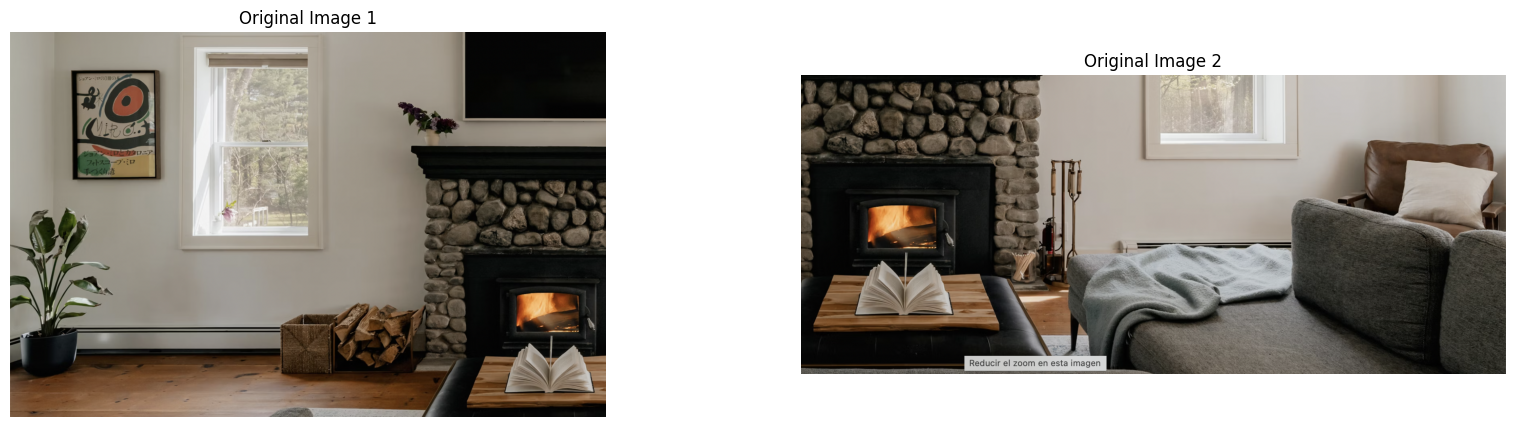

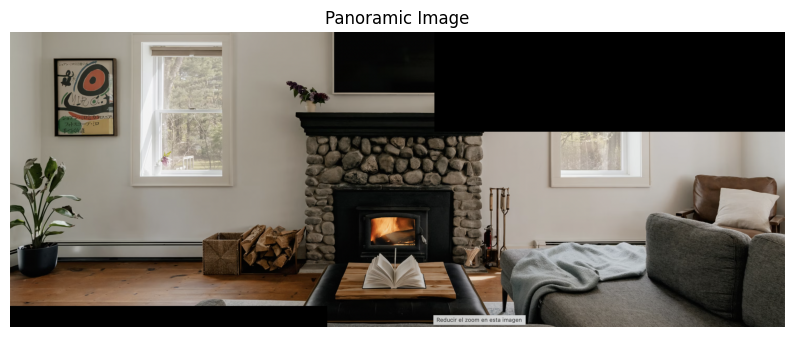

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
images = []
for i in reversed(range(2)):
    image = cv2.imread(os.path.join(images_dir, input_dir, f's{i+1}.png'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    images.append(image)

homography_12 = find_homography(images[0], images[1])
warped_img_12 = warping(images[0], images[1], homography_12)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(warped_img_12, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

IMAGE HEIGHT: 216
IMAGE HEIGHT: 210
IMAGE HEIGHT: 214


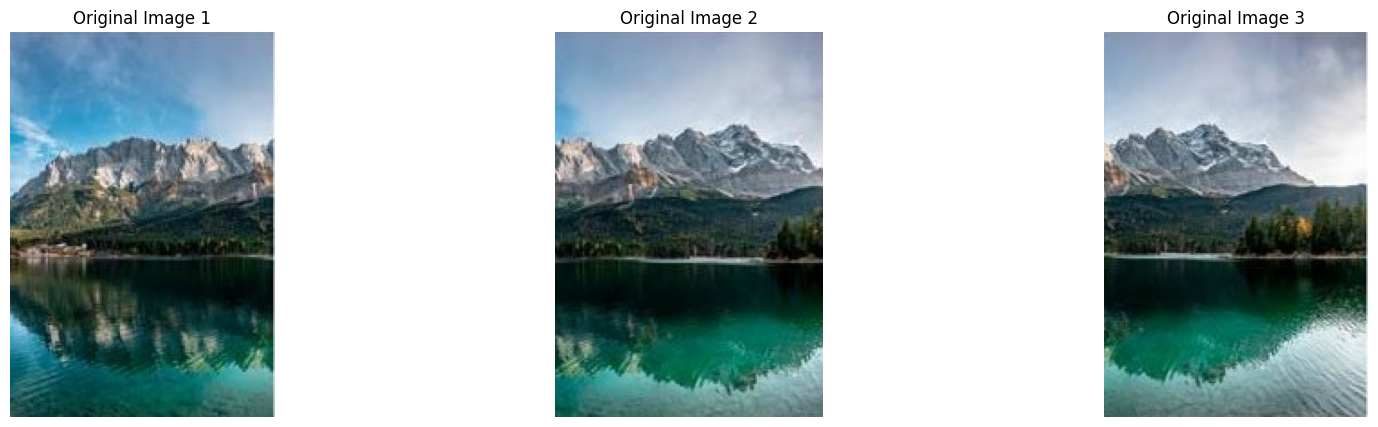

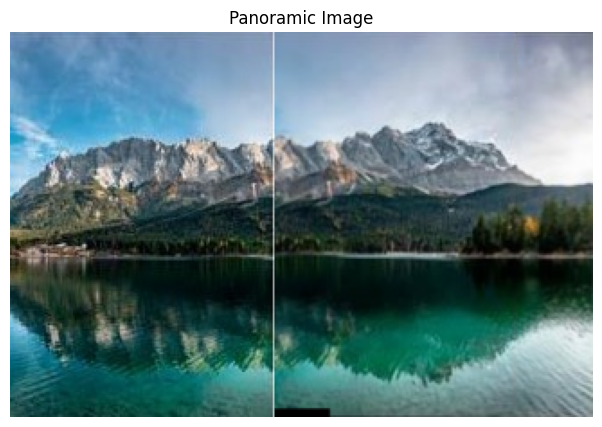

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
images = []
for i in reversed(range(3)):
    image = cv2.imread(os.path.join(images_dir, input_dir, f'e{i+1}.jpg'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    print(f"IMAGE HEIGHT: {image.shape[0]}")
    images.append(image)

homography_12 = find_homography(images[0], images[1])
homography_23 = find_homography(images[1], images[2])

warped_img_12 = warping(images[0], images[1], homography_12)
final_warped_img = warping(warped_img_12, images[2], np.dot(homography_23, homography_12))

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(final_warped_img, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

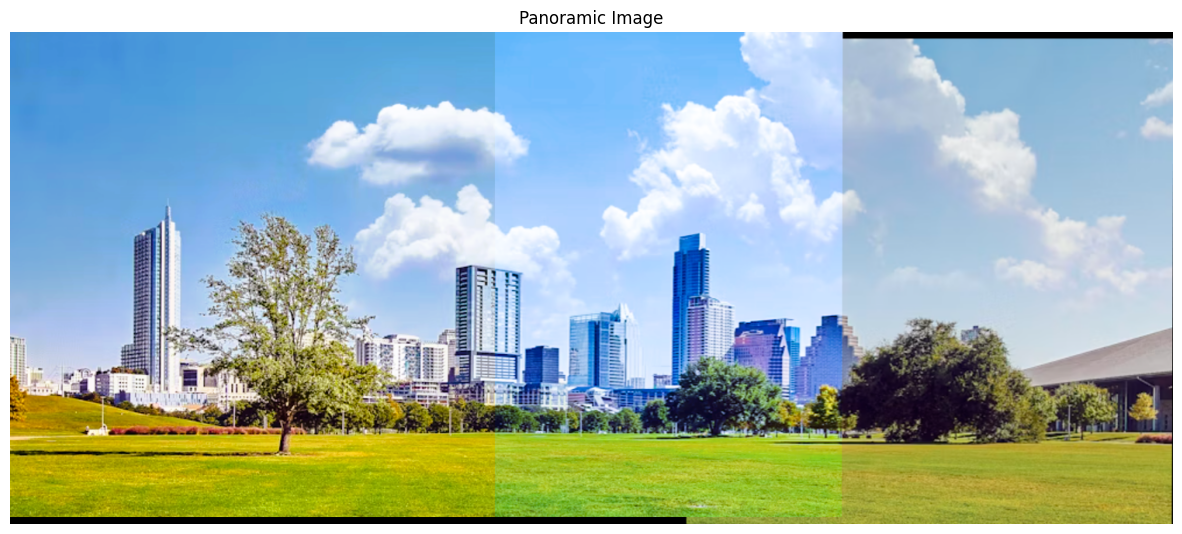

In [7]:
#  Carga las imágenes
images_dir = "imagenes/input0"
image_files = ['a3.png', 'a2.png', 'a1.png']
images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# Calcula las homografías y crea la imagen panorámica
previous_image = images[0]
for i in range(1, len(images)):
    H = find_homography(previous_image, images[i])
    if H is not None:
        previous_image = warping(previous_image, images[i], H)

# Visualiza el resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
plt.title("Panoramic Image")
plt.axis('off')
plt.show()

## WARPING WITH BLENDING (DEGRADADO ENTRE IMAGENES)
El algoritmo de blending codificado utiliza una técnica de fusión basada en un degradado (gradiente) para combinar dos imágenes que se superponen parcialmente, logrando una transición suave en la zona donde ambas imágenes se encuentran. La clave de esta técnica radica en el cálculo de una "máscara de degradado", donde se establece un arreglo de valores que cambian gradualmente de 1 a 0. Esta máscara se aplica sobre el rango de columnas donde las imágenes se superponen. Utilizando esta máscara, el algoritmo modifica la opacidad con la que se combinan los píxeles de cada imagen en la región superpuesta, asignando un peso mayor a la imagen original hacia el inicio del degradado y disminuyendo este peso a medida que se avanza hacia el otro extremo de la superposición, permitiendo así una integración visual más natural y menos abrupta.

En la práctica, este proceso se lleva a cabo identificando primero las áreas de superposición entre las dos imágenes y las áreas donde no hay superposición. En las áreas de superposición, se aplica la máscara de degradado calculada previamente, realizando una operación de mezclado pixel por pixel y canal por canal (RGB). Esto significa que para cada canal de color, el valor del pixel resultante se calcula como una combinación ponderada de los valores correspondientes de las dos imágenes, según los valores especificados en la máscara de degradado. Por otro lado, en las áreas donde solo existe información de una de las imágenes, simplemente se copian los píxeles correspondientes a la imagen fuente directamente al resultado final, sin realizar mezcla alguna, asegurando que la totalidad del canvas resultante contenga una fusión coherente y visualmente agradable de ambas entradas.

In [8]:
def warping(img1, img2, homography):
    height_img1, width_img1 = img1.shape[:2]
    height_img2, width_img2 = img2.shape[:2]

    # Calcular dimensiones de la imagen de salida
    output_width = width_img1 + width_img2
    output_height = max(height_img1, height_img2)

    # Warp img1 con la homografía
    img1_warped = cv2.warpPerspective(img1, homography, (output_width, output_height))
    mask1_warped = cv2.warpPerspective(np.ones((height_img1, width_img1), dtype=np.uint8), homography, (output_width, output_height))

    # Preparar el canvas para el resultado final
    result = np.zeros((output_height, output_width, 3), dtype=img1.dtype)
    
    # Preparar la imagen y máscara de img2 en el canvas extendido
    img2_extended = np.zeros((output_height, output_width, 3), dtype=img2.dtype)
    img2_extended[:height_img2, :width_img2] = img2
    mask2_extended = np.zeros((output_height, output_width), dtype=np.uint8)
    mask2_extended[:height_img2, :width_img2] = 1

    # Identificar áreas de superposición y no superposición
    overlap = (mask1_warped == 1) & (mask2_extended == 1)
    non_overlap1 = (mask1_warped == 1) & (mask2_extended == 0)
    non_overlap2 = (mask1_warped == 0) & (mask2_extended == 1)

    if np.any(overlap):
        rows, cols = np.where(overlap)
        min_col, max_col = cols.min(), cols.max()
        gradient_width = max_col - min_col + 1
        alpha = np.linspace(1, 0, gradient_width)  # Invertir la dirección del degradado

        # Crear una máscara de degradado completa para la región de superposición
        full_alpha = np.zeros_like(img1_warped[:, :, 0], dtype=float)
        full_alpha[:, min_col:max_col+1] = alpha

        # Usar la máscara de degradado para el blending
        for c in range(3):  # Repetir para cada canal de color
            result[overlap, c] = (img1_warped[overlap, c] * (1 - full_alpha[overlap]) + img2_extended[overlap, c] * full_alpha[overlap]).astype(np.uint8)
    
    # Donde solo img1 tiene datos
    result[non_overlap1] = img1_warped[non_overlap1]
    
    # Donde solo img2 tiene datos
    result[non_overlap2] = img2_extended[non_overlap2]

    return result


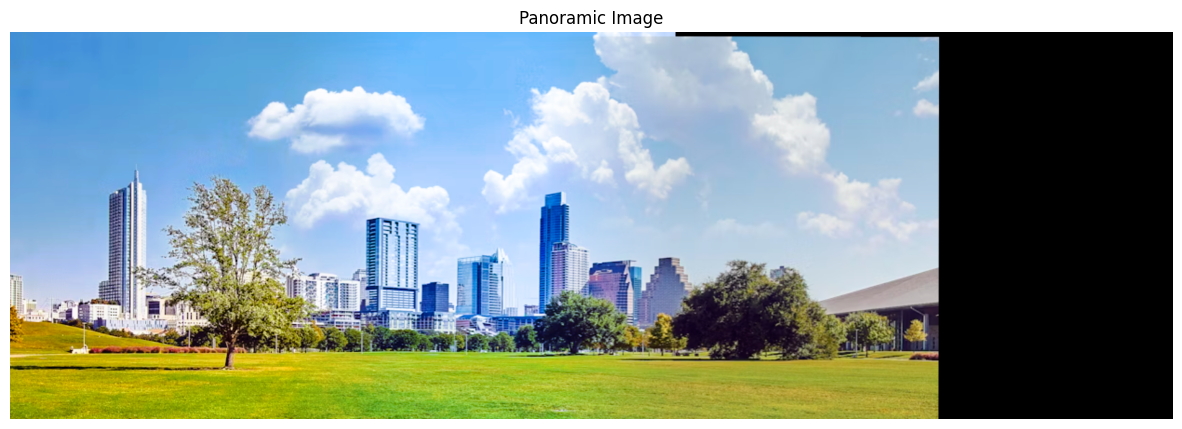

In [9]:
#  Carga las imágenes
images_dir = "imagenes/input0"
image_files = ['a3.png', 'a2.png', 'a1.png']
images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# Calcula las homografías y crea la imagen panorámica
previous_image = images[0]
for i in range(1, len(images)):
    H = find_homography(previous_image, images[i])
    if H is not None:
        previous_image = warping(previous_image, images[i], H)

# Visualiza el resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
plt.title("Panoramic Image")
plt.axis('off')
plt.show()